## 1. Generate training simulation images according to csv file

<br />
This feature will generate images from csv files based on your evaluation model and will provide you with images of the selected track for referance and comparison.

Run this code if it's your first time using this notebook:

                                  pip install deepracer-utils

#### Follow these steps step by step
1. Log in to deepracer console
2. Select your training models on the left
3. Choose your model
4. Select the teaining mode
5. Download your evaluation logs
6. Unzip your log files

#### Run the code in the following unit and select your csv file and track name.

###  <span style="color: green;">What is training mode and what is evaluation mode? </span>


#### In AWS DeepRacer, training mode and evaluation mode are two separate phases for training and evaluating the performance of the reinforcement learning agent. Here are the main differences:

#### Training mode：
1. In training mode, the agent (DeepRacer vehicle) interacts with the environment (the track) and learns a strategy. It optimizes this strategy by trying different actions and observing the results.
2. The training mode involves a balance between exploration and exploitation. Exploration is when an agent tries a new action to find the best possible strategy, while exploitation is when an agent chooses an action based on a learned strategy.
3. The goal of the training mode is for the agent to learn and find the optimal strategy through as much trial and error as possible. The performance of the agent may be erratic during training.

#### Evaluation mode：
1. The evaluation mode is conducted after the training is complete. In the evaluation mode, the agent performs actions in the environment (on the track) based on strategies learned during the training phase.
2. In evaluation mode, the agent focuses on exploiting learned strategies rather than continuing to explore new actions. As a result, there is little or no exploration under the assessment model.
3. The goal of the evaluation pattern is to measure the agent's performance against the learned strategy. It helps you see if the training process works and how the agent performs in real life.

In conclusion, the training model focuses on the process of learning strategies, while the evaluation model focuses on the performance of learned strategies in practice. In the context of DeepRacer, the training mode is used to optimize the agent's behavior, while the evaluation mode is used to measure its performance on the track.




#### Run the code and download the necessary libraries

In [48]:
from deepracer.tracks import TrackIO, Track

from deepracer.logs import \
    AnalysisUtils as au, \
    SimulationLogsIO as slio, \
    EvaluationUtils as eu, \
    PlottingUtils as pu

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [49]:
from datetime import datetime
class PlottingUtilsCustom(pu):
    @staticmethod
    def plot_evaluations_save(evaluations, track: Track, path, graphed_value='speed', groupby_field='episode'):
        """Plot graphs for evaluations
        """
        from math import ceil

        if groupby_field not in evaluations:
            if 'unique_episode' in evaluations:
                groupby_field = 'unique_episode'
                print("Grouping by 'unique_episode'")

        streams = evaluations.sort_values(
            'tstamp', ascending=False).groupby('stream', sort=False)

        for _, stream in streams:
            episodes = stream.groupby(groupby_field)
            ep_count = len(episodes)

            rows = ceil(ep_count / 3)
            columns = min(ep_count, 3)
            
            plt.figure(figsize=(10,5))
            fig, axes = plt.subplots(rows, columns, figsize=(7*columns, 5*rows))
            fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=7.0)

            for id, episode in episodes:
                if rows == 1:
                    ax = axes[id % 3]
                elif columns == 1:
                    ax = axes[int(id/3)]
                else:
                    ax = axes[int(id / 3), id % 3]

                PlottingUtilsCustom.plot_grid_world(
                    episode, track, graphed_value, ax=ax)
                
            plt.subplots_adjust(top=0.85)
            plt.savefig(path)
            plt.show()
            plt.clf()
            
    @staticmethod
    def plot_grid_world_save(
            episode_df,
            track: Track,
            path,
            graphed_value='speed',
            min_progress=None,
            cmap=None):
        episode_df.loc[:, 'distance_diff'] = ((episode_df['x'].shift(1) - episode_df['x']) ** 2 + (
            episode_df['y'].shift(1) - episode_df['y']) ** 2) ** 0.5

        distance = np.nansum(episode_df['distance_diff'])
        lap_time = np.ptp(episode_df['tstamp'].astype(float))
        velocity = distance / lap_time
        average_speed = np.nanmean(episode_df['speed'])
        progress = np.nanmax(episode_df['progress'])

        if not min_progress or progress > min_progress:

            distance_lap_time = 'Distance, progress, lap time = %.2f m, %.2f %%, %.2f s' % (
                distance, progress, lap_time
            )
            speed_velocity = 'Average speed, velocity = %.2f (Gazebo), %.2f m/s' % (
                average_speed, velocity
            )

            fig = plt.figure(figsize=(16, 10))
            ax = fig.add_subplot(1, 1, 1)

            line = LineString(track.inner_border)
            PlottingUtils._plot_coords(ax, line)
            PlottingUtils._plot_line(ax, line)

            line = LineString(track.outer_border)
            PlottingUtils._plot_coords(ax, line)
            PlottingUtils._plot_line(ax, line)

            if cmap is None:
                cmap = plt.get_cmap('plasma')

            episode_df.plot.scatter('x', 'y', ax=ax, s=3, c=graphed_value,
                                    cmap=cmap)

            subtitle = '%s%s\n%s\n%s' % (
                ('Stream: %s, ' % episode_df['stream'].iloc[0]
                 ) if 'stream' in episode_df.columns else '',
                datetime.fromtimestamp(episode_df['tstamp'].iloc[0]),
                distance_lap_time,
                speed_velocity)
            ax.set_title(subtitle)
            plt.subplots_adjust(top=0.85)
            plt.savefig(path)
            plt.show()
            plt.clf()

#### Upload your log files, and copy the name of the log files into the 'logs'

In [50]:
logs = [['evaluation-20230315234311-W79tkqQnQzCHEbz6M-B04w-robomaker.log', '20230315234311']]

In [51]:
 # Loads all the logs from the above time range 
bulk = slio.load_a_list_of_logs(logs)

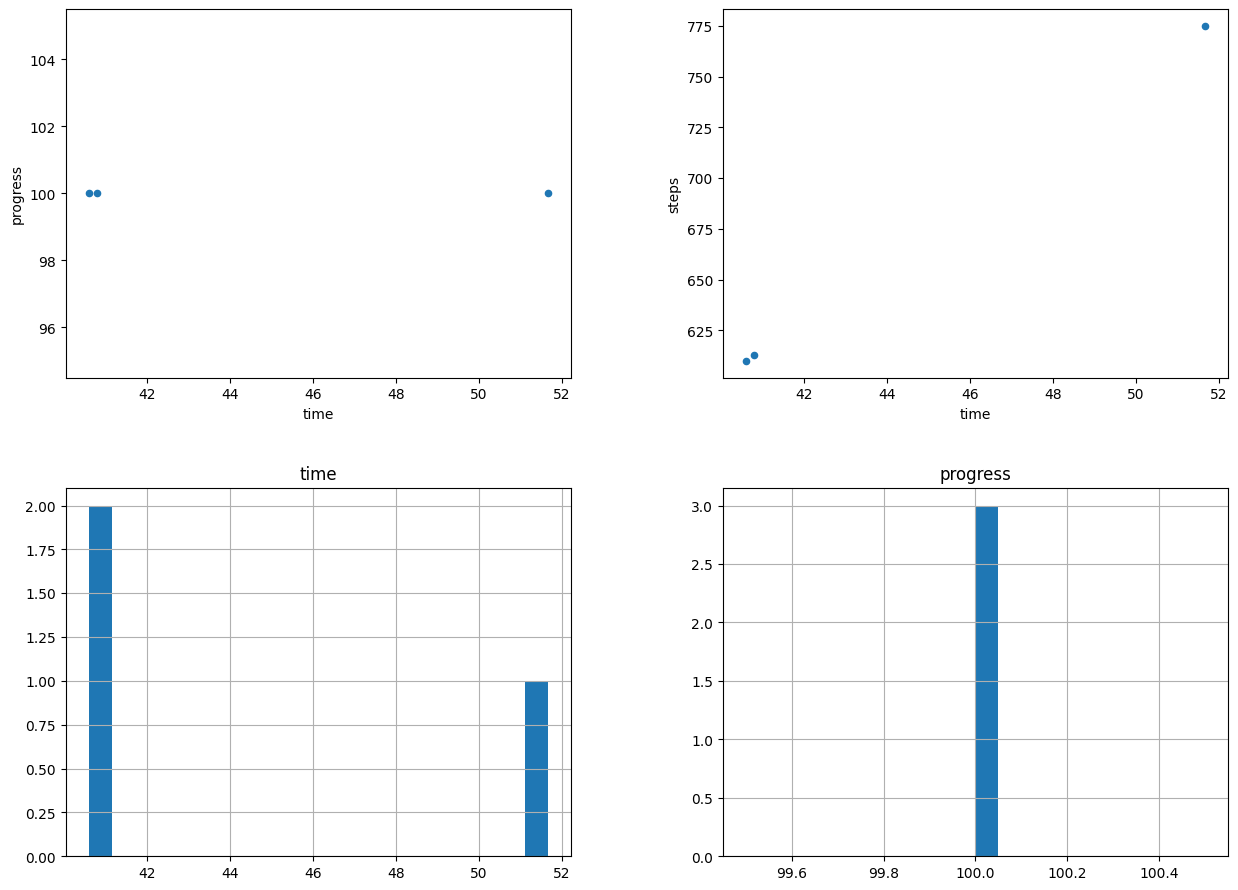

<Figure size 640x480 with 0 Axes>

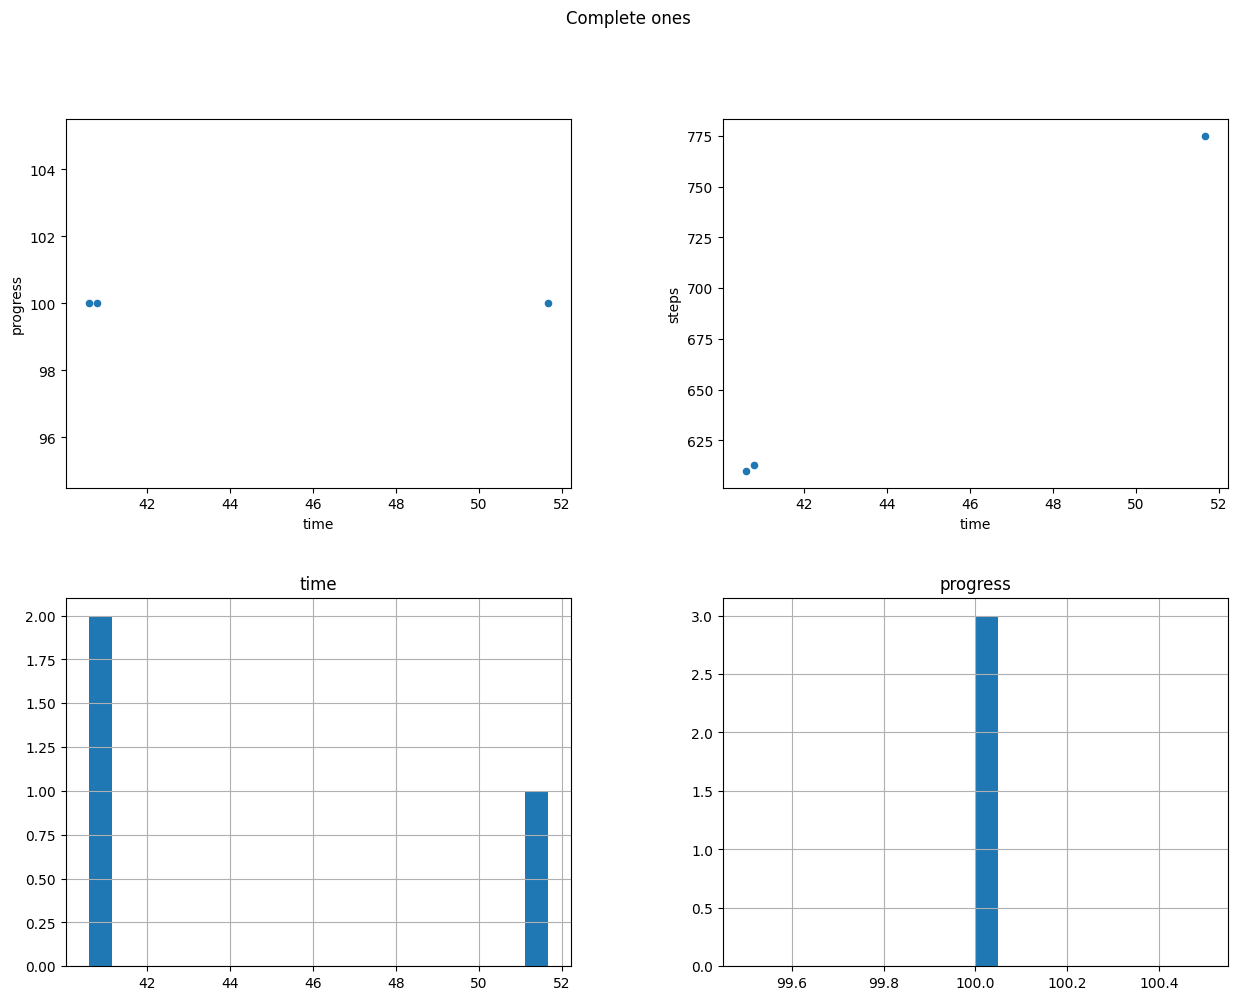

<Figure size 640x480 with 0 Axes>

In [52]:
simulation_agg = au.simulation_agg(bulk, 'stream', is_eval=True)
complete_ones = simulation_agg[simulation_agg['progress']==100]

au.scatter_aggregates(simulation_agg, is_eval=True)
if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, "Complete ones", is_eval=True)

In [53]:
# View fifteen most progressed attempts
simulation_agg.nlargest(15, 'progress')

,stream,episode,steps,start_at,progress,time,dist,speed,crashed,off_track,time_if_complete,complete
0,20230315234311,0,775,0,100.0,51.672,35.330404,0.731858,0,4,51.672,1
1,20230315234311,1,610,0,100.0,40.602,31.291110,0.698852,0,0,40.602,1
2,20230315234311,2,613,0,100.0,40.803,31.256211,0.691403,0,0,40.803,1


In [54]:
# View fifteen fastest complete laps
complete_ones.nsmallest(15, 'time')

,stream,episode,steps,start_at,progress,time,dist,speed,crashed,off_track,time_if_complete,complete
1,20230315234311,1,610,0,100.0,40.602,31.291110,0.698852,0,0,40.602,1
2,20230315234311,2,613,0,100.0,40.803,31.256211,0.691403,0,0,40.803,1
0,20230315234311,0,775,0,100.0,51.672,35.330404,0.731858,0,4,51.672,1


In [55]:
    import os
    from IPython.display import display
    import ipywidgets as widgets
    from deepracer.tracks import TrackIO, Track

    track_dir = "./maps"
    # show all the npy file
    npy_files = [f for f in os.listdir(track_dir) if f.endswith('.npy')]

    # Create a drop-down menu
    dropdown = widgets.Dropdown(
        options=npy_files,
        description='Track files:',
    )

    # Create a global variable to hold the selected file name and Track object
    global track
    track = None
    tu = TrackIO()

    # Creates a function that takes a file name as an argument and loads the file
    def load_track(file_name):
        global track
        track = tu.load_track(os.path.join(track_dir, file_name))

    # Create an interactive interface
    widgets.interact(load_track, file_name=dropdown)

interactive(children=(Dropdown(description='Track files:', options=('2022_april_open.npy', '2022_april_pro.npy…

<function __main__.load_track(file_name)>

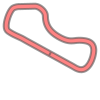

In [56]:
track.road_poly

In [62]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
import numpy as np
from matplotlib import colors
cmap = plt.cm.cool
norm = colors.Normalize(vmin=0, vmax=100) # assuming speed ranges from 0 to 100


<Figure size 1000x500 with 0 Axes>

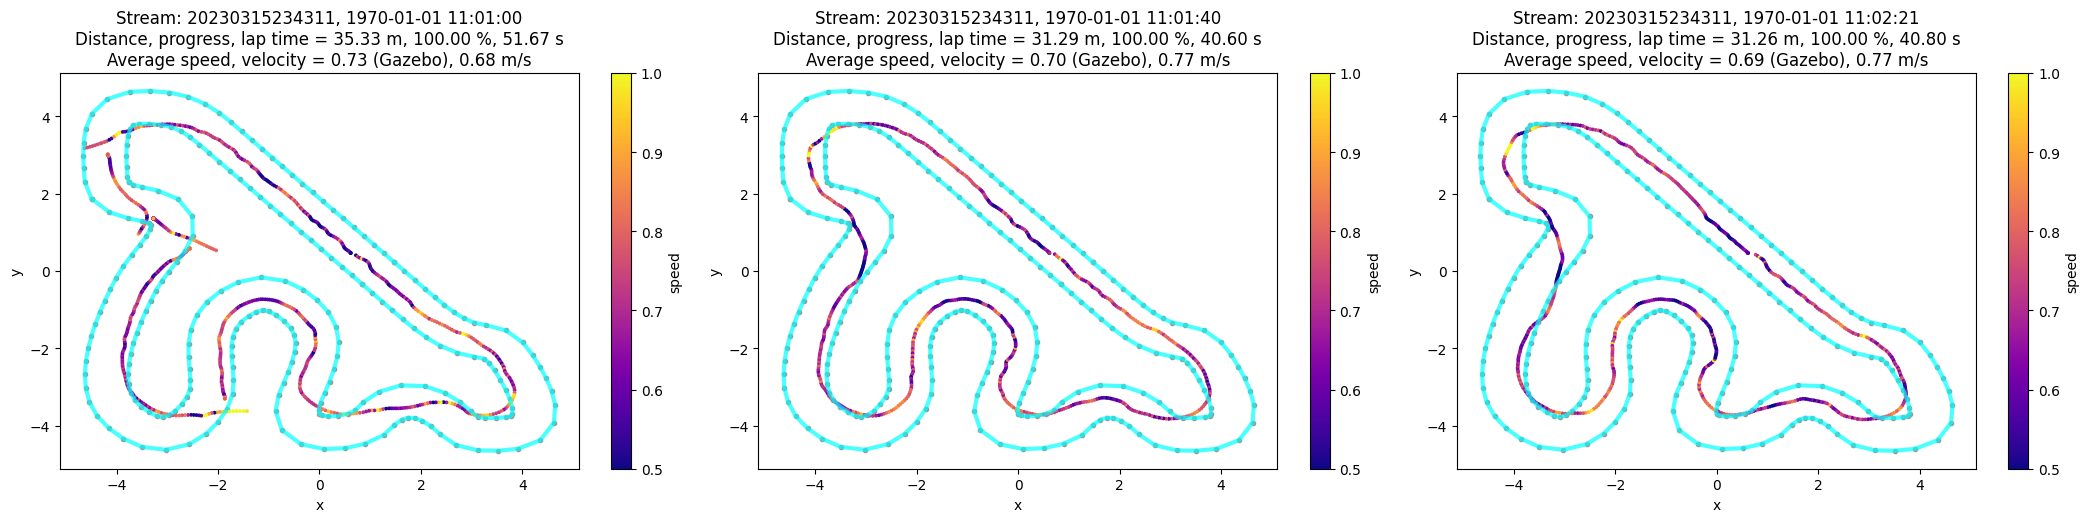

<Figure size 640x480 with 0 Axes>

In [63]:
from shapely.geometry import LineString

class PlottingUtils:
    @staticmethod
    def _plot_coords(ax, line):
        x, y = line.xy
        ax.plot(x, y, '.', color='#999999', zorder=1)
    
    @staticmethod
    def _plot_line(ax, line):
        x, y = line.xy
        ax.plot(x, y, color='#6699cc', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)
    
    def plot_evaluations(self, bulk, track, plot_title='Evaluation run'):
        for i in bulk['episode'].unique():
            episode_df = bulk.loc[bulk['episode'] == i]
            plt.scatter(episode_df['x'], episode_df['y'], color=cmap(norm(episode_df['speed'])), s=1)
            
        # Convert numpy arrays to LineStrings
        inner_border = LineString(track.inner_border.tolist())
        outer_border = LineString(track.outer_border.tolist())
        
        PlottingUtils._plot_coords(plt.gca(), inner_border)
        PlottingUtils._plot_coords(plt.gca(), outer_border)
        PlottingUtils._plot_line(plt.gca(), inner_border)
        PlottingUtils._plot_line(plt.gca(), outer_border)
        
        plt.title(plot_title)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.gca().invert_yaxis()
        plt.axis('equal')
        plt.show()

pu = PlottingUtilsCustom()
pu.plot_evaluations_save(bulk, track, 'saved_images/speed_graph.png')

In [64]:
#pu.plot_evaluations(bulk, track)

In [65]:
# Load a single lap
lap_df = bulk[(bulk['episode']==0) & (bulk['stream']==logs[0][1])]

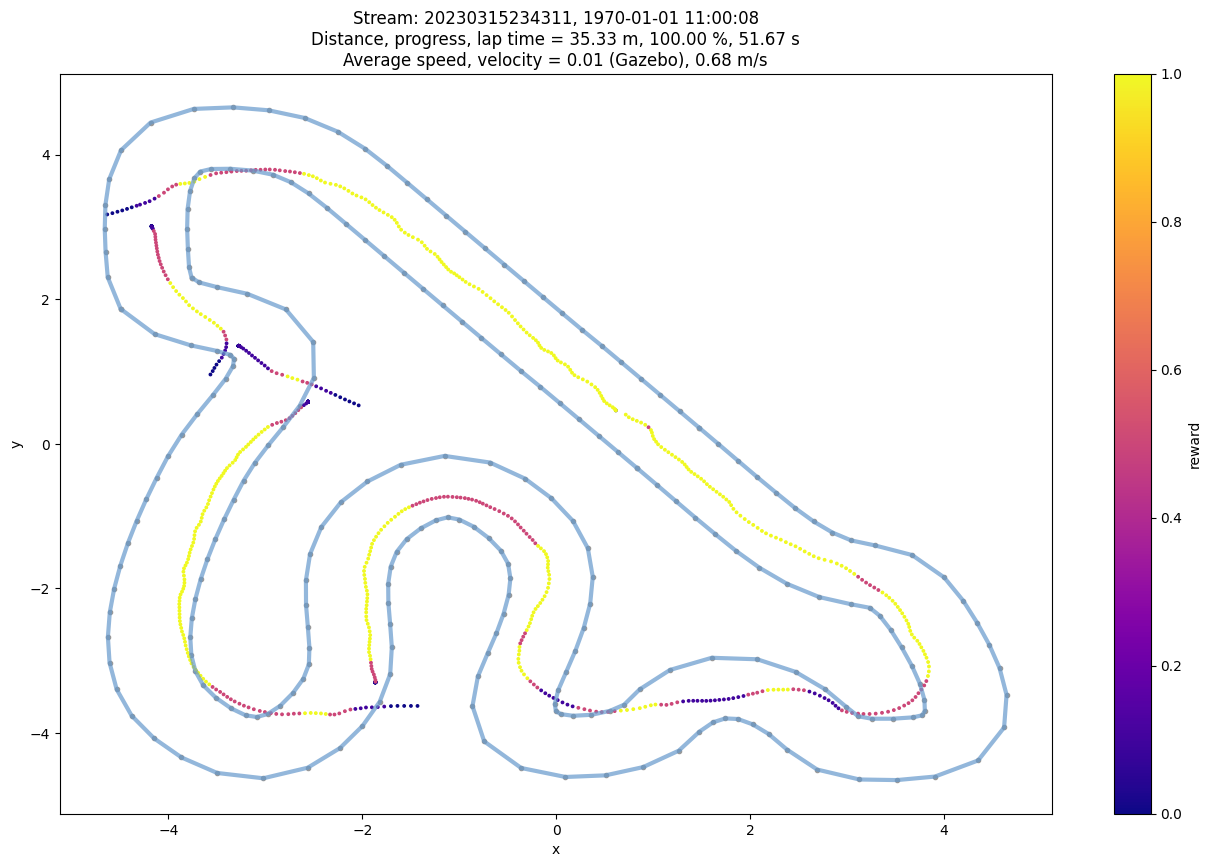

<Figure size 640x480 with 0 Axes>

In [66]:
lap_df.loc[:,'distance']=((lap_df['x'].shift(1)-lap_df['x']) ** 2 + (lap_df['y'].shift(1)-lap_df['y']) ** 2) ** 0.5
lap_df.loc[:,'time']=lap_df['tstamp'].astype(float)-lap_df['tstamp'].shift(1).astype(float)
lap_df.loc[:,'speed']=lap_df['distance']/(100*lap_df['time'])
lap_df.loc[:,'acceleration']=(lap_df['distance']-lap_df['distance'].shift(1))/lap_df['time']
lap_df.loc[:,'progress_delta']=lap_df['progress'].astype(float)-lap_df['progress'].shift(1).astype(float)
lap_df.loc[:,'progress_delta_per_time']=lap_df['progress_delta']/lap_df['time']

pu.plot_grid_world_save(lap_df, track,'saved_images/reward_graph.png' , graphed_value='reward')